In [1]:
# used for data augmentation
!pip install -U git+https://github.com/albumentations-team/albumentations
# timm pytorch image model
!pip instal timm
# all modules (main and contrib)
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-8krl9ysh
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-8krl9ysh
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125709 sha256=a088bbc3018d7a7a2c7c5b4c7265ed839dae51e6afdead40f6791903740fdd20
  Stored in directory: /tmp/pip-ephem-wheel-cache-2305l_xm/wheels/6d/72/93/d30af2a1f90e7c7e811e8fa43aa723971c91af45052ffa1b5a
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
E

In [2]:
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 38.36 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

## Preprocessing

In [6]:
train = pd.read_csv(CSV_FILE)
train

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


In [7]:
from google.colab.patches import cv2_imshow

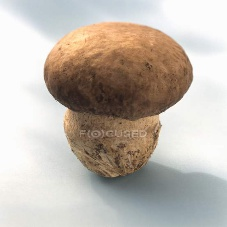

In [8]:
row = train.iloc[185]
img = cv2.imread(DATA_DIR + row['img_path'])
cv2_imshow(img)

In [9]:
#BGR is a default format when loading a picture
# application uses RGB
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [10]:
# Define the top-left and bottom-right corners of the rectangle
pt1 = (row['xmin'],row['ymin'])
pt2 = (row['xmax'],row['ymax'])

In [11]:
# img , (top left),(bottom right), (color of rectangle (default BGR) we have converted to RGB), (thickness)
bnd_box = cv2.rectangle(img,pt1,pt2,(255,0,0),2)

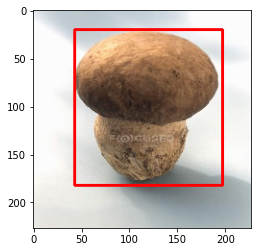

In [12]:
plt.imshow(img)

In [13]:
train_df, valid_df = train_test_split(train, test_size = 0.2, random_state = 42)

In [14]:
print(train_df.shape)
print(valid_df.shape)
print(train.shape)

(148, 8)
(38, 8)
(186, 8)


## Augmentation

we have only 185 data which is very low we need to augemnt some data.

In [15]:
import albumentations as A
IMG_SIZE = 140

In [16]:
# first parameter applies to train (horizontalflip and verticalflip with prob of 0.5)
# second parameter applies to bounding box (Specifies the bounding box format of the dataset, Specifies the label field to be used in the data to identify the class/label of the object in each bounding box.)
train_augs = A.Compose(
    [A.Resize(IMG_SIZE,IMG_SIZE),A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),A.Rotate()],
    bbox_params = A.BboxParams(format='pascal_voc',label_fields=['class_labels'])
)

In [17]:
valid_augs = A.Compose(
    [A.Resize(IMG_SIZE,IMG_SIZE)], 
    bbox_params = A.BboxParams(format='pascal_voc',label_fields=['class_labels'])
)

## Custom Dataset

In [18]:
class ObjectDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentation):
    self.df = df
    self.augmentation = augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    row = self.df.iloc[index]

    bbox = [[row.xmin,row.ymin,row.xmax,row.ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentation:
      data = self.augmentation(image = img, bboxes = bbox, class_labels = [None]) # only localize => don't need class_labels
      img = data['image']
      bbox = data['bboxes'][0] # [[xmin,ymin,xmax,ymax]]
    # move the channel dimension from 2nd position to 0th position as Torch tensor expects channels to appear first
    img = torch.from_numpy(img).permute(2,0,1)
    bbox = torch.Tensor(bbox)

    return img,bbox

In [19]:
trainset = ObjectDataset(train_df,train_augs)
validset = ObjectDataset(valid_df,valid_augs)

In [20]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


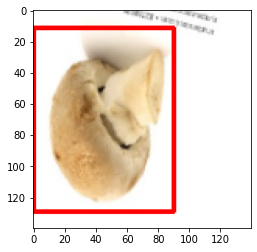

In [21]:
img, bbox = trainset[100]
xmin, ymin, xmax, ymax = bbox
pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))
bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(), pt1, pt2, (255,0,0), 2)  # cv2 use np instead of tensor
plt.imshow(bnd_img)

In [22]:
BATCH_SIZE = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size = BATCH_SIZE,shuffle=True)

In [23]:
print(f'number of train batches: {len(trainloader)}')
print(f'number of validation batches: {len(validloader)}')

number of train batches: 10
number of validation batches: 3


In [24]:
for i,(img,bbox) in enumerate(trainloader):
  print(f'a batch for images: {img.shape}')
  print(f'a batch for bboxes: {bbox.shape}')
  break;
# first is batch size, channel, height,weight
# first is batch size , 4 is size of bounding box (x_min, y_min, x_max, y_max)

a batch for images: torch.Size([16, 3, 140, 140])
a batch for bboxes: torch.Size([16, 4])


## Model

In [25]:
from torch import nn
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.9 MB/s eta 0:00:00


In [26]:
timm.models.list_models() 

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

See the explaination of EfficientNet [here](https://medium.com/mlearning-ai/understanding-efficientnet-the-most-powerful-cnn-architecture-eaeb40386fad).

In [27]:
# we are going to use efficient models since we are limited by compute power and memory such as EfficientNet, MobileNetV3, and RegNet.
timm.list_models('*efficient*')

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnet

In [28]:
MODEL_NAME = 'efficientnet_b0'
class ObjectModel(nn.Module):
  def __init__(self):
    super(ObjectModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4) #output without softmax
  def forward(self, images, gt_bboxes= None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes,loss
    return bboxes

In [29]:
model = ObjectModel()
device = 'cuda'
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


ObjectModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [30]:
rnd_img = torch.rand(1,3,140,140).to(device)
model(rnd_img).shape

torch.Size([1, 4])

## Training

In [31]:
def ModelTrain(model,dataloader,optimizer):
  train_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    img,gt_bbox = data
    img = img.type(torch.cuda.FloatTensor)
    img,gt_bbox = img.to(device),gt_bbox.to(device)
    bboxes,loss = model(img,gt_bbox)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  return train_loss / len(dataloader)

In [32]:
def ModelValid(model,dataloader):
  valid_loss = 0.0
  model.eval()
  with torch.no_grad():
    for img,gt_bbox in tqdm(dataloader):
      img = img.type(torch.cuda.FloatTensor)
      img,gt_bbox = img.to(device), gt_bbox.to(device)
      bboxes, loss = model(img,gt_bbox)
      valid_loss += loss.item()
    return valid_loss/len(dataloader)

In [33]:
LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [34]:
EPOCHES = 50
best_loss = np.Inf
for i in range(EPOCHES):
  train_loss = ModelTrain(model,trainloader,optimizer)
  valid_loss = ModelValid(model,validloader)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'model.pt')
    print('saved!')
    best_loss = valid_loss

  print(f"Epoch : {i+1} train loss: {train_loss} valid loss: {valid_loss}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 1 train loss: 5231.645263671875 valid loss: 5606.076171875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 2 train loss: 1924.7741821289062 valid loss: 2524.113566080729


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 3 train loss: 1105.878759765625 valid loss: 244.82809448242188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 4 train loss: 791.2985717773438 valid loss: 223.6281534830729


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 5 train loss: 535.2866790771484 valid loss: 187.39762369791666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss: 393.9046600341797 valid loss: 229.0713653564453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 train loss: 365.01451721191404 valid loss: 242.33394368489584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 8 train loss: 253.24018249511718 valid loss: 176.45526123046875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 9 train loss: 184.4031204223633 valid loss: 148.68710581461588


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 10 train loss: 166.82700576782227 valid loss: 135.26627349853516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 11 train loss: 149.27698287963867 valid loss: 124.1919428507487


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12 train loss: 104.07577362060547 valid loss: 132.60313415527344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 train loss: 101.80693969726562 valid loss: 150.57394663492838


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 14 train loss: 92.1374755859375 valid loss: 111.09273274739583


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss: 87.98655700683594 valid loss: 114.95769755045573


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 16 train loss: 92.23847351074218 valid loss: 94.41886774698894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss: 84.24612007141113 valid loss: 117.4747085571289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 train loss: 76.81009292602539 valid loss: 102.96464538574219


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 19 train loss: 98.71906776428223 valid loss: 82.62270863850911


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 20 train loss: 65.89468688964844 valid loss: 63.014031728108726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss: 67.15417175292968 valid loss: 99.86300404866536


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss: 80.08833084106445 valid loss: 69.99568939208984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss: 57.97212524414063 valid loss: 72.08533477783203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 24 train loss: 60.87669906616211 valid loss: 50.93688201904297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss: 48.995840072631836 valid loss: 58.46577707926432


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved!
Epoch : 26 train loss: 51.149491500854495 valid loss: 45.19814682006836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 train loss: 43.982977104187015 valid loss: 50.10661252339681


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss: 55.00801010131836 valid loss: 86.03175099690755


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss: 42.30383777618408 valid loss: 119.23336283365886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss: 42.2676456451416 valid loss: 55.82587496439616


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss: 52.879190826416014 valid loss: 51.04861831665039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss: 39.10725994110108 valid loss: 85.55768330891927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss: 41.67302074432373 valid loss: 53.59447352091471


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss: 46.232572364807126 valid loss: 55.67427317301432


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss: 45.49445743560791 valid loss: 81.28062057495117


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss: 39.57480049133301 valid loss: 72.4744046529134


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss: 43.111505317687985 valid loss: 77.0464719136556


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss: 44.491047096252444 valid loss: 57.964717864990234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss: 38.29767055511475 valid loss: 54.39668528238932


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss: 39.33507823944092 valid loss: 66.0096549987793


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 41 train loss: 33.92151298522949 valid loss: 65.61017100016277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 42 train loss: 39.15969734191894 valid loss: 53.520181020100914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 43 train loss: 29.825840187072753 valid loss: 64.77055994669597


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 44 train loss: 39.99268341064453 valid loss: 56.849222819010414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 45 train loss: 39.73394966125488 valid loss: 74.31548690795898


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 46 train loss: 41.66740093231201 valid loss: 58.256900787353516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 47 train loss: 41.50846424102783 valid loss: 87.11071523030598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 48 train loss: 40.12741527557373 valid loss: 60.10044542948405


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 49 train loss: 40.382147789001465 valid loss: 76.77124150594075


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 50 train loss: 42.008560752868654 valid loss: 78.34479014078777


## Inference

In [35]:
import cv2
import numpy
import torch 
import matplotlib.pyplot as plt 
from IPython.display import Image

In [36]:
def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    image=image.squeeze().permute(1, 2, 0).cpu().numpy()


    out_img = cv2.rectangle(image,pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
  
    out_img = cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB)

    cv2_imshow(out_img) 



In [37]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

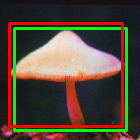

In [38]:
with torch.no_grad():
  image,gt_box = validset[5]
  image = image.type(torch.cuda.FloatTensor)
  image = image.unsqueeze(0).to(device)
  out_bbox = model(image)
  compare_plots(image, gt_box, out_bbox)